In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dcor
from minepy import MINE

## merge clinical and transcriptome data

In [20]:
df_clin = pd.read_csv('../data/MAARS_AD_full_20190131_12-34-49.csv', sep='\t')
df_clin_all = pd.read_csv('../data/MAARS_all_Fri_Apr_04_14h_CEST_2014.csv', sep='\t')
df_gen = pd.read_csv('../data/MAARS_normTranscriptome_618samples_16042014.txt', sep='\t')

df_genenames = pd.read_csv('../data/ensembl2gene.txt')

df_clin = df_clin.fillna('NaN')
df_gen_t = df_gen.transpose()

gene_cols = df_gen_t.columns

In [21]:
df_merge1 = pd.merge(df_gen_t, df_clin_all, how='left', left_index=True, right_on='sample_id')

df_merge2 = pd.merge(df_clin, df_merge1, 
                     left_on='involved skin biopsy#involved skin biopsy#MAARS Sample identifier (MAARS_Sample_identifier)', 
                     right_on='sample_id', how='inner')

## check properties of merged dataframe

In [22]:
for col in ['lesional', 'Gender', 'clinical_group', 'anatomical_location']:
    print()
    print(df_merge2[col].value_counts())



LES    83
Name: lesional, dtype: int64

Male      47
Female    36
Name: Gender, dtype: int64

AD    83
Name: clinical_group, dtype: int64

posterior_thigh    44
upper_back         37
lower_back          2
Name: anatomical_location, dtype: int64


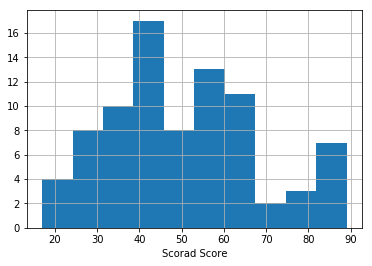

In [23]:
df_merge2['patient#SCORAD index#SCORAD#SCORAD Score (SCORAD_Score)'].hist()
plt.xlabel('Scorad Score')

## Non-linear correlations between Scorad Score and expression level of each gene

In [24]:
# target                                                  
target_col = 'patient#SCORAD index#SCORAD#SCORAD Score (SCORAD_Score)'          
y = df_merge2[target_col].values                           
                                                              
# genes                                                   
X = df_merge2[gene_cols].values               
                                                              
mic_scores = []                                           
distance_correlation = []                                 
# loop over all genes                                     
for x in X.T:                                             
                                                          
    mine = MINE(alpha=0.6, c=15, est="mic_approx")        
    mine.compute_score(x, y)                              
                                                            
    mic_scores.append(mine.mic())                         
                                                              
    dc = dcor.distance_correlation(x,y)
                                                              
    distance_correlation.append(dc)                       
                                                        

#### as a reference value, calculate non-linear correlation for random vectors drawn from the same distribution

In [25]:
# get values for random vectors
nsamples = 50
mic_scores_random = []
distance_correlation_random = []
for i in range(nsamples):
    x_sampled = np.random.choice(X.flatten(), size=len(y))
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x_sampled, y)
    mic_scores_random.append(mine.mic())

    dc = dcor.distance_correlation(x,y)

    distance_correlation_random.append(dc)
    
distance_correlation_random = np.asarray(distance_correlation_random)
mic_scores_random = np.asarray(mic_scores_random)

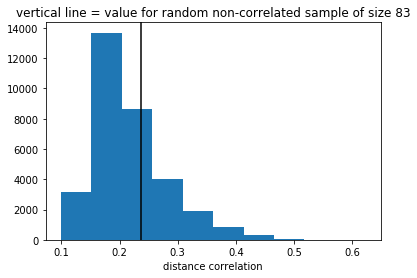

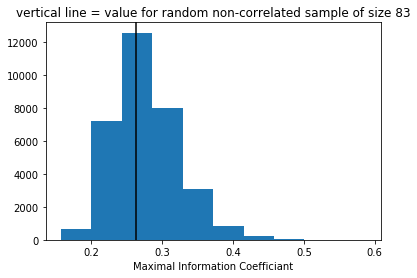

In [26]:
plt.clf()
plt.hist(distance_correlation)
plt.axvline(distance_correlation_random.mean(), color='k')
plt.xlabel('distance correlation')
plt.title('vertical line = value for random non-correlated sample of size {}'.format(len(y)))
#plt.savefig('distance_correlation.png', bbox_inches='tight')
plt.show()

plt.clf()
plt.hist(mic_scores)
plt.axvline(mic_scores_random.mean(), color='k')
plt.xlabel('Maximal Information Coefficiant')
plt.title('vertical line = value for random non-correlated sample of size {}'.format(len(y)))
#plt.savefig('mic.png', bbox_inches='tight')
plt.show()

### Is there a correlation between the two measures of non-linear SCORAD/gene correlation ?

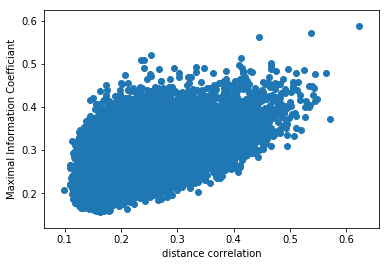

In [27]:
plt.clf()
plt.scatter(distance_correlation, mic_scores)
plt.xlabel('distance correlation')
plt.ylabel('Maximal Information Coefficiant')

### genes with highest correlation with SCORAD score

In [28]:
df_results = pd.DataFrame({'distance_correlation': distance_correlation, 
                           'mic': mic_scores, 
                           'gene_names': gene_cols})
df_results['EnsemblID'] = df_results['gene_names'].str.slice(0,15)
df_results = pd.merge(df_results, df_genenames, on='EnsemblID', how='left')

In [29]:
df_results.sort_values(by='mic', ascending=False).head(10)

,distance_correlation,mic,gene_names,EnsemblID,GeneSymbol
9479,0.622199,0.586804,ENSG00000153993_at,ENSG00000153993,SEMA3D
15514,0.537866,0.570310,ENSG00000186205_at,ENSG00000186205,MARC1
5662,0.445726,0.561462,ENSG00000126016_at,ENSG00000126016,AMOT
27006,0.253284,0.521024,ENSG00000242736_at,ENSG00000242736,TRBV1
1791,0.412746,0.513236,ENSG00000089009_at,ENSG00000089009,RPL6
25913,0.241020,0.509332,ENSG00000237556_at,ENSG00000237556,KCND3-AS1
5177,0.235284,0.507582,ENSG00000122550_at,ENSG00000122550,KLHL7
5377,0.465945,0.501449,ENSG00000124224_at,ENSG00000124224,PPP4R1L
10476,0.409378,0.498065,ENSG00000162437_at,ENSG00000162437,RAVER2
12905,0.466789,0.494672,ENSG00000172201_at,ENSG00000172201,ID4


In [30]:
df_results.sort_values(by='distance_correlation', ascending=False).head(10)

,distance_correlation,mic,gene_names,EnsemblID,GeneSymbol
9479,0.622199,0.586804,ENSG00000153993_at,ENSG00000153993,SEMA3D
37,0.572121,0.371095,ENSG00000003400_at,ENSG00000003400,CASP10
9329,0.564277,0.477909,ENSG00000152580_at,ENSG00000152580,IGSF10
10172,0.547896,0.418335,ENSG00000160097_at,ENSG00000160097,FNDC5
30763,0.545379,0.476615,ENSG00000256433_at,ENSG00000256433,RP1-102E24.8
5233,0.545161,0.414835,ENSG00000123095_at,ENSG00000123095,BHLHE41
7622,0.542191,0.444296,ENSG00000139292_at,ENSG00000139292,LGR5
4766,0.541390,0.428414,ENSG00000118900_at,ENSG00000118900,UBN1
6804,0.539327,0.449149,ENSG00000134851_at,ENSG00000134851,TMEM165
15514,0.537866,0.570310,ENSG00000186205_at,ENSG00000186205,MARC1


## Agreement between MIC and Distance Correlation

In [31]:
ngenes_threshold = 200
genes_selected_mic = df_results.sort_values(by='mic', ascending=False)['EnsemblID'].values[:ngenes_threshold]
genes_selected_dc = df_results.sort_values(by='distance_correlation', ascending=False)['EnsemblID'].values[:ngenes_threshold]

intersection = set([g for g in genes_selected_dc if g in genes_selected_mic])
union = set(genes_selected_dc + genes_selected_mic)
jaccard_similarity = len(intersection) / len(union)
print(jaccard_similarity)

0.24


## Output

In [34]:
df_output = df_results[df_results['distance_correlation'] > distance_correlation_random.mean()]

df_output.sort_values(by='distance_correlation', 
                      ascending=False)[['gene_names', 
                                        'EnsemblID', 
                                        'GeneSymbol', 
                                        'distance_correlation']].to_csv('Distance_correlation_SCORAD_gene_selection_Aoife.csv', index=False)


In [35]:
df_output = df_results[df_results['mic'] > mic_scores_random.mean()]
df_output.sort_values(by='mic', 
                      ascending=False)[['gene_names', 
                                        'EnsemblID', 
                                        'GeneSymbol', 
                                        'mic']].to_csv('Maximal_information_coefficient_SCORAD_gene_selection_Aoife.csv', index=False)
